In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import pandas as pd
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import roc_auc_score, accuracy_score, \
balanced_accuracy_score, confusion_matrix, roc_curve, auc, \
precision_recall_fscore_support
from sklearn.preprocessing import LabelBinarizer

import copy
import warnings 
import os 
import random
warnings.filterwarnings("ignore")

import umap
from numpy import linalg as LA
from helper import *

In [2]:
METHODS = ['fedavg', 'fca']

LOSS_OPTION = ['ce','focal','bsm']
SPLIT_1 = {'clients':10, 'split_path':'ich_datasplit_10cl.npy'}
SPLIT_2 = {'clients':5, 'split_path':'ich_datasplit_5cl.npy'}


NUM_CLASS = 5
BATCH_SIZE = 64
NUM_WORKERS = 8

epochs = 80
lr, momentum, wd = 1e-3, 0.9, 5e-4
epochs_lr_decay  = [60, 70]
lr_decay = 0.1
device = torch.device('cuda:0')

color_code = ['b','g','r','c','m','y','k']

## select the experiment setting

In [3]:
# extra hyperparameter for FCA, LAM1 = global, LAM2 = local
LAM1, LAM2, CONSISTENCY = 1,3, True

FCA_PARAMS = {'LAM1':LAM1,'LAM2':LAM2, 'CONSISTENCY':CONSISTENCY}

SPLIT_SETTING = SPLIT_1
# SPLIT_SETTING = SPLIT_2
LOSS_ = LOSS_OPTION[2] 


SELECTED = METHODS[1] 
if SELECTED == 'fca':
    FCA_ = True
    head = ['standard_head2.weight','standard_head2.bias']
else:
    FCA_ = False
    head = []

In [4]:
TOTAL_CLIENTS = SPLIT_SETTING['clients']
PTH = '../datasets/ich/'
PTH_split = SPLIT_SETTING['split_path']
train_split = np.load(PTH_split, allow_pickle=True).item()
train_data, test_data = train_split['train'], train_split['test']
CLIENTS = [str(i) for i in range(TOTAL_CLIENTS)]

## load the data

In [5]:
test_all_img = np.array([])
test_all_lbl = np.array([])

train_all_img = np.array([])
train_all_lbl = np.array([])
for cl in CLIENTS:
    train_data[cl] = dict()
    test_data[cl] = dict()
    train_data[cl]['image'] = PTH+'images/'+train_data[int(cl)]['image']+'.png'
    test_data[cl]['image'] = PTH+'images/'+test_data[int(cl)]['image']+'.png'
    train_data[cl]['label'] = train_data[int(cl)]['label']
    test_data[cl]['label'] = test_data[int(cl)]['label']
    
    train_all_img = np.concatenate((train_all_img, train_data[cl]['image']))
    train_all_lbl = np.concatenate((train_all_lbl, train_data[int(cl)]['label']))
    
    test_all_img = np.concatenate((test_all_img, test_data[cl]['image']))
    test_all_lbl = np.concatenate((test_all_lbl, test_data[int(cl)]['label']))
    
train_data['global'] = {"image":train_all_img, "label":train_all_lbl}
test_data['global'] = {"image":test_all_img, "label":test_all_lbl}

## dataloader

In [6]:
norm_mean = [ 0.456]
norm_std = [0.224]
class cancer(Dataset):
    def __init__(self, im_path, class_label, \
                 transformation=None, num_class=5):
        self.data = im_path
        self.label = class_label
        self.transform = transformation
        self.num_class = num_class
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self,idx):
        image = Image.open(self.data[idx])
        if self.transform: # augmentation
            image = self.transform(image)
        else:
            image = Resize((128,128))(image)
            image = TF.to_tensor(image)
        label = self.label[idx]
        label_onehot = torch.FloatTensor(self.num_class).zero_()
        label_onehot[label] = 1.0
        
        return image, label, idx, label_onehot
    
input_transform_train = Compose([
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    RandomRotation(degrees=(-10,10)),
    Resize((128,128)),
    ToTensor(),
    Normalize(norm_mean, norm_std)
])

input_transform_test = Compose([
    Resize((128,128)),
    ToTensor(),
    Normalize(norm_mean, norm_std)
])

In [7]:
CE_loss = nn.CrossEntropyLoss(reduction='none')
clsnm_, criterions_, loader = dict(), dict(), dict()
_, clsnm_global = np.unique(train_data['global']['label'], return_counts=True)

for cl_name in CLIENTS:
    loader['train_'+cl_name] = DataLoader(cancer(train_data[cl_name]['image'], \
                                               train_data[cl_name]['label'], input_transform_train), \
                                        shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    loader['test_'+cl_name] = DataLoader(cancer(test_data[cl_name]['image'], \
                                               test_data[cl_name]['label'], input_transform_test), \
                                        batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    cls, clsnm = np.unique(train_data[cl_name]['label'], return_counts=True)
    clsnm_[cl_name] = np.zeros(NUM_CLASS)
    for idx, i in enumerate(cls):
        clsnm_[cl_name][i] = clsnm[idx]
        
    if LOSS_ == 'ce':
        criterions_[cl_name] = CE_loss
    if LOSS_ == 'focal':
        criterions_[cl_name] = FocalLoss(gamma=1)
    if LOSS_ == 'bsm':
        criterions_[cl_name] = CustomLoss(clsnm_[cl_name], \
                                          CE_loss,device, balance=True)

loader['global_train'] = DataLoader(cancer(train_data['global']['image'], \
                                               train_data['global']['label'], input_transform_train), \
                                        shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
loader['global'] = DataLoader(cancer(test_data['global']['image'], \
                                               test_data['global']['label'], input_transform_test), \
                                        shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [8]:
# binarize label
label_binarizer = LabelBinarizer().fit(train_data['global']['label'].astype('int'))

########
global eval
avg auc now: 0.8546828474080614 avg auc best: 0.8551489972978148
overall set acc last epoch:  0.5347036057884184  best,  0.560133449557823
#######
pc eval
avg acc per client, 0.6449949858485308 0.6449949858485308
avg auc now: 0.8542949136950838 avg auc best: 0.8542949136950838


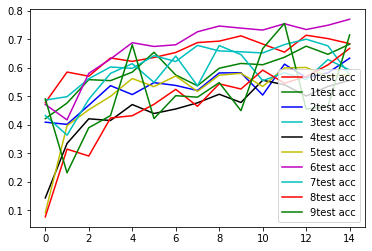

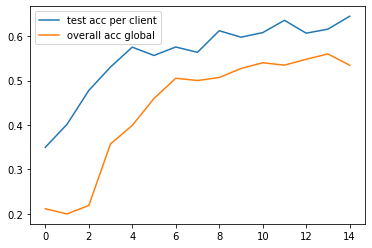

epoch number 15 


In [ ]:
best_avg_acc = 0.0
best_global_acc = 0.0
epoch_best_avg = 0
epoch_best_global_avg = 0

acc_train, loss_train, acc_test = dict(), dict(), dict() 
avg_auc_ = dict()
avg_auc_['global']= []

nets, optimizers, schedulers = dict(), dict(), dict()
weights = dict()

index = [] 
#### additional storage ####
test_acc_avg = []
best_test_acc = []
overall_acc_test = []
pc_avg_auc=[]

###############################################
### federated model #####
tmp = models.efficientnet_b0(pretrained=True)
tmp.features[0][0] = nn.Conv2d(1,32, kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False)
tmp.classifier[1] = nn.Linear(in_features=1280, out_features=NUM_CLASS, bias=True)
if FCA_:
    nets['global'] = customized_effnet(tmp, classnum=NUM_CLASS)
else:
    nets['global'] = tmp
nets['global'].to(device)
##########################
total = 0
num_client = 0
for key,_ in loader.items():
    if key[:4] == 'test':
        tmp = key[5:]
        acc_train[tmp], loss_train[tmp] = [], []
        acc_test[tmp] = []
        avg_auc_[tmp] = []
        #########################################
        weights[tmp] = len(loader['train_'+tmp].dataset)
        total += weights[tmp]
        num_client += 1
        tmp_ = models.efficientnet_b0(pretrained=True)
        tmp_.features[0][0] = nn.Conv2d(1,32, kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False)
        tmp_.classifier[1] = nn.Linear(in_features=1280, out_features=NUM_CLASS, bias=True)
        if FCA_:
            nets[tmp] = customized_effnet(tmp_, classnum=NUM_CLASS)
        else:
            nets[tmp] = tmp_
        nets[tmp].to(device)
        optimizers[tmp] = optim.Adam(nets[tmp].parameters(), lr=lr, \
           weight_decay=wd)
        schedulers[tmp] = optim.lr_scheduler.MultiStepLR(optimizers[tmp],
                                                      milestones=epochs_lr_decay,
                                                      gamma=lr_decay)
# assign federated average weight
WEIGHTS_CL = np.zeros(num_client)
for idx, cl_name in enumerate(CLIENTS):
    WEIGHTS_CL[idx] = weights[cl_name]/total * 1.0

for epoch in range(80):
    index.append(epoch) 
    print("epoch number %d " % epoch)
    # aggregate model and download to client
    aggr_fed(CLIENTS, WEIGHTS_CL, nets, fed_name='global', head=[])
    copy_fed(CLIENTS, nets, fed_name='global', head=head)
    '''
    Evaluate federated model - global evaluation / generalization
    '''
    criterion = nn.CrossEntropyLoss().to(device)
    test(loader['global'], nets['global'], criterion, device, \
        acc_arr=overall_acc_test, avg_auc=avg_auc_['global'], \
         global_=True, FCA_=FCA_, label_binarizer=label_binarizer, NUM_CLASS=NUM_CLASS)   
    
    '''
    training
    '''
    for client, _ in acc_train.items():        
        criterion = criterions_[client]
        schedulers[client].step() # step        
        train(loader['train_'+client], nets[client], optimizers[client], \
                  criterion, device,acc_arr= acc_train[client], loss_arr=loss_train[client], FCA_=FCA_,\
             FCA_PARAMS=FCA_PARAMS)

    '''
    per client evaluation - specialization
    '''
    avg_acc = 0.0
    avg_auc = 0
    criterion = nn.CrossEntropyLoss().to(device)
    for client, _ in acc_test.items():
        test(loader['test_'+client], nets[client], criterion, device, \
            acc_test[client], avg_auc=avg_auc_[client], \
             global_=False, FCA_=FCA_, label_binarizer=label_binarizer, NUM_CLASS=NUM_CLASS)
        avg_acc += acc_test[client][-1]
        avg_auc += avg_auc_[client][-1]
        
    test_acc_avg.append(avg_acc/TOTAL_CLIENTS)
    pc_avg_auc.append(avg_auc/TOTAL_CLIENTS)
    avg_acc = avg_acc/TOTAL_CLIENTS
    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        epoch_best_avg = epoch
    if overall_acc_test[-1] > best_global_acc:
        best_global_acc = overall_acc_test[-1]
        epoch_best_global_avg = epoch
                
    clear_output(wait=True)
    
    print('########')
    print('global eval')
    print('overall set acc last epoch: ', overall_acc_test[-1], ' best, ', \
         overall_acc_test[epoch_best_global_avg])
    print('avg auc now:', avg_auc_['global'][-1], \
         'avg auc best:', avg_auc_['global'][epoch_best_global_avg])
    print('#######')
    print('pc eval')
    print('avg acc per client,',test_acc_avg[-1], best_avg_acc)
    print('avg auc now:', pc_avg_auc[-1], \
         'avg auc best:', pc_avg_auc[epoch_best_avg])


    plot_graphs(1, CLIENTS, index, acc_test, 'test acc')
    plt.figure(2)
    plt.plot(index, test_acc_avg, label= 'test acc per client')
    plt.plot(index, overall_acc_test, label='overall acc global')
    plt.legend()
    plt.show()